In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Loading data :
train = pd.read_csv(r'C:\Users\Rehaan\train.csv', parse_dates=['date'])
test = pd.read_csv(r'C:\Users\Rehaan\test.csv', parse_dates=['date'])
sample_sub = pd.read_csv(r'C:\Users\Rehaan\sample_submission.csv')
print('Train shape:{}, Test shape:{}'.format(train.shape, test.shape))
train.head()
test.head()

Train shape:(913000, 4), Test shape:(45000, 4)


,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [3]:
#Number of unique store and item :
print("number of unique items :",train.item.nunique())
print("number of unique store :",train.store.nunique())

number of unique items : 50
number of unique store : 10


In [4]:
#date features :
train['dayofmonth'] = train.date.dt.day
train['dayofyear'] = train.date.dt.dayofyear
train['dayofweek'] = train.date.dt.dayofweek
train['month'] = train.date.dt.month
train['year'] = train.date.dt.year
train['weekofyear'] = train.date.dt.isocalendar().week
train.head()
train.shape


(913000, 10)

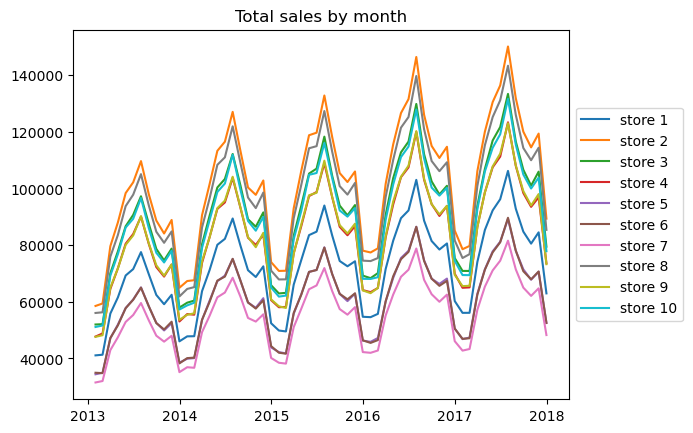

In [5]:
for i in range(1,11):
    month_df = train[train.store==i].resample('M',on='date').sum()
    x= np.array(month_df.index)
    y=np.array(month_df.sales)
    plt.plot(x,y,label = 'store %s' % i)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title("Total sales by month")
plt.show()

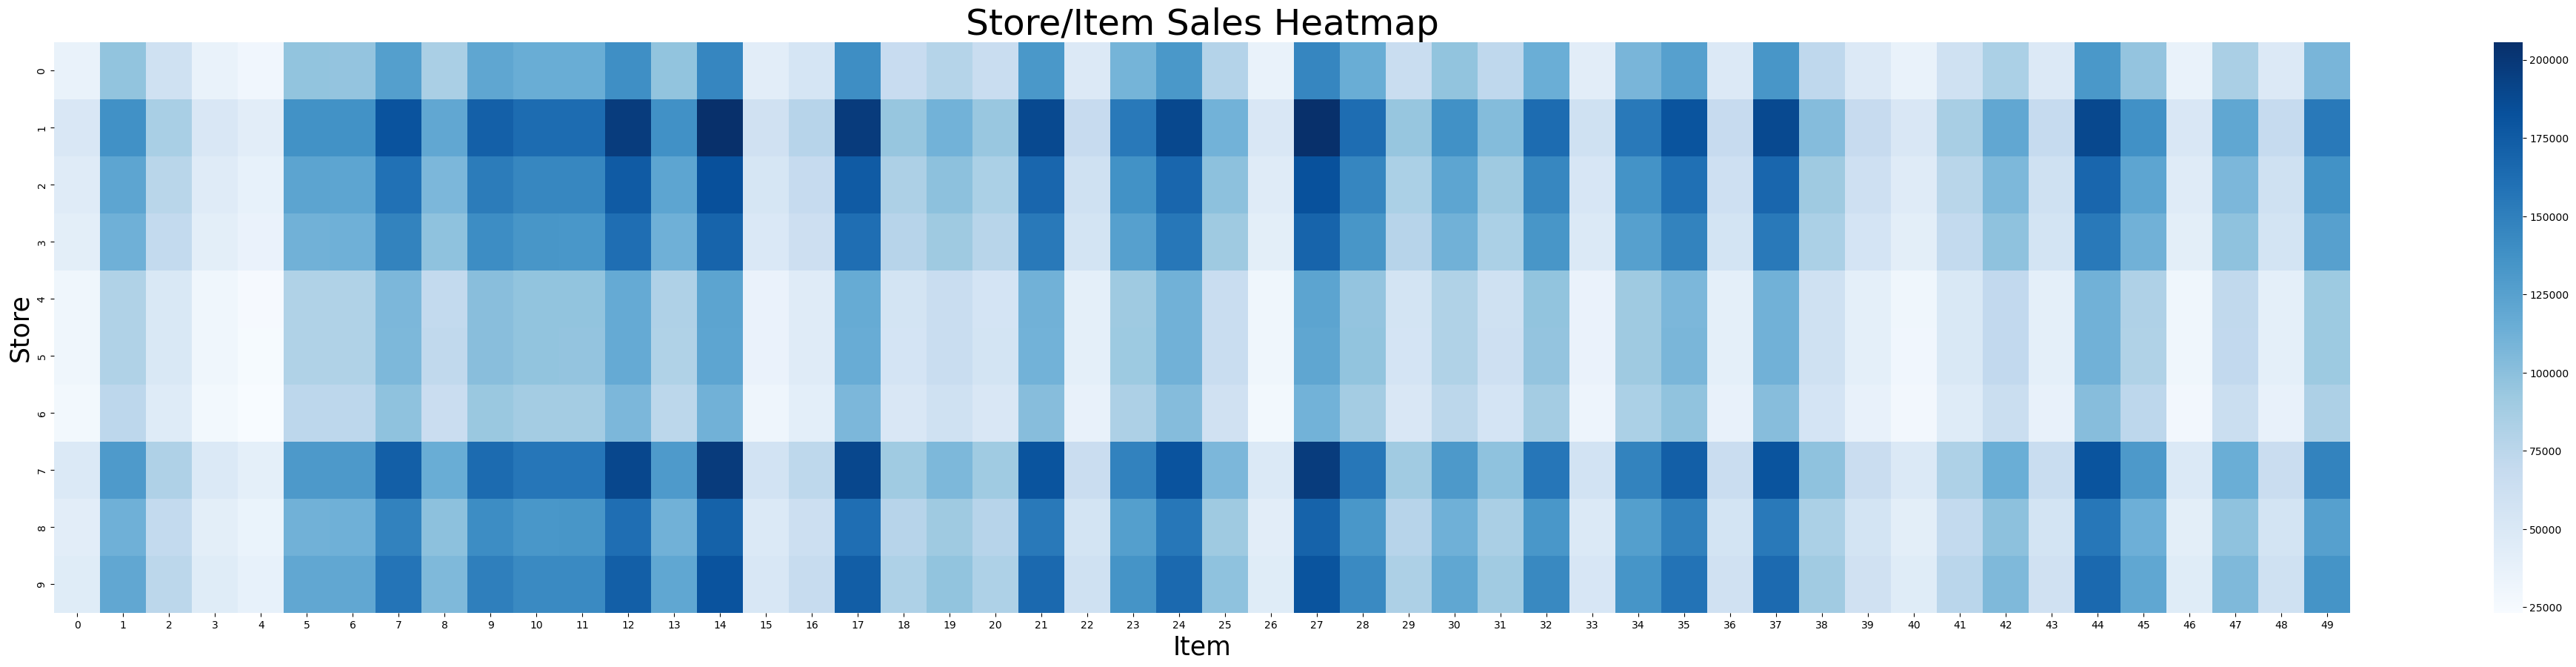

In [6]:
# Exclude the 'date' column from the groupby operation
store_item_df = train.groupby(['store', 'item'], as_index=False)['sales'].sum()

# Create an empty matrix to store sales data
matrixStoreItem = np.zeros((10, 50))

# Fill the matrix with sales data
for i in range(1, 11):
    for j in range(1, 51):
        # Find the corresponding sales value for store i and item j
        sales_value = store_item_df[(store_item_df['store'] == i) & (store_item_df['item'] == j)]['sales'].values
        if len(sales_value) > 0:
            matrixStoreItem[i-1, j-1] = sales_value[0]

# Plot the heatmap
plt.figure(figsize=(50, 10))
ax = sns.heatmap(matrixStoreItem, cmap='Blues')
plt.xlabel("Item", fontsize=25)
plt.ylabel("Store", fontsize=25)
plt.title("Store/Item Sales Heatmap", fontsize=35)
plt.show()


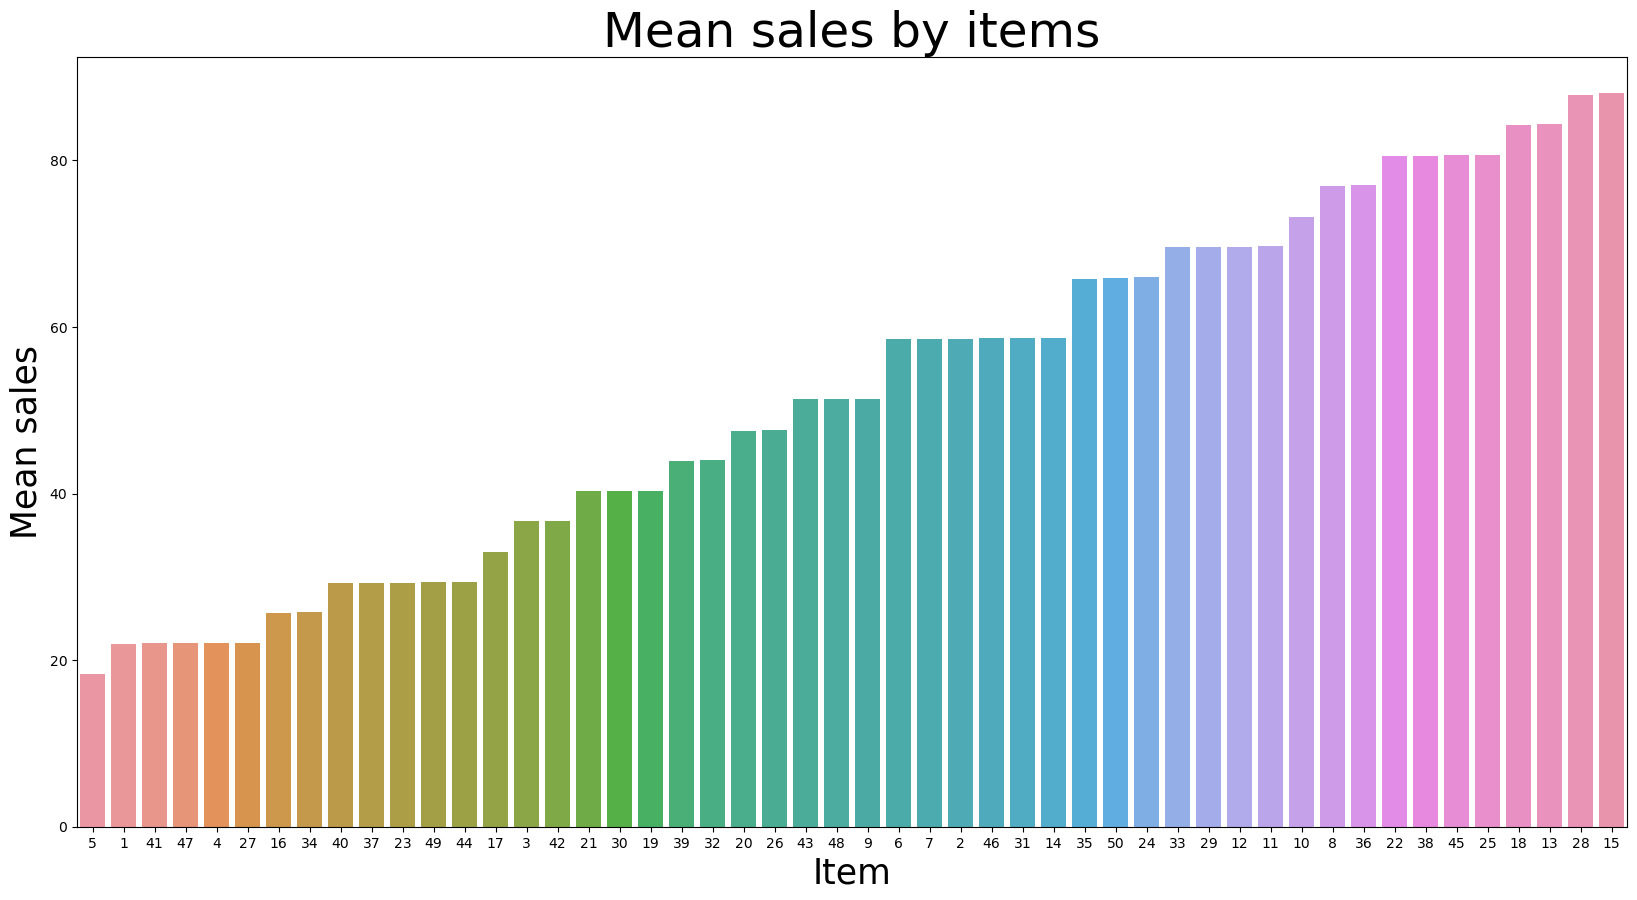

In [7]:
plt.close('all')
item_df = train.groupby(['item']).mean()
item_df.sort_values('sales',ascending=True,inplace=True)
x = item_df.index
y = item_df.sales
plt.figure(figsize=(20,10))
sns.barplot(x=x, y=y, order=x)
plt.xlabel("Item",fontsize = 25)
plt.ylabel("Mean sales",fontsize=25)
plt.title("Mean sales by items",fontsize=35)
plt.show()

In [8]:
# dummies features : 
df = pd.get_dummies(train, columns = ['store','item','dayofmonth','dayofweek','month','weekofyear'])
df.head()

,date,sales,dayofyear,year,store_1,store_2,store_3,store_4,store_5,store_6,...,weekofyear_44,weekofyear_45,weekofyear_46,weekofyear_47,weekofyear_48,weekofyear_49,weekofyear_50,weekofyear_51,weekofyear_52,weekofyear_53
0,2013-01-01,13,1,2013,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2013-01-02,11,2,2013,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,2013-01-03,14,3,2013,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,2013-01-04,13,4,2013,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,2013-01-05,10,5,2013,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [9]:
#train and validation dataframe :
msk = np.random.rand(len(df)) < 0.8
df_train = df[msk]
df_val = df[~msk]
print("train shape: ",df_train.shape)
print("validation shape :",df_val.shape)

train shape:  (729904, 167)
validation shape : (183096, 167)


In [10]:
df_train.drop('date',axis=1,inplace=True)
df_val.drop('date',axis=1,inplace=True)
y_train = df_train['sales'].values
y_test = df_val['sales'].values
X_train = df_train.drop('sales', axis=1).values
X_test = df_val.drop('sales', axis=1).values

C:\Users\Rehaan\AppData\Local\Temp\ipykernel_27724\2141025894.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.drop('date',axis=1,inplace=True)
C:\Users\Rehaan\AppData\Local\Temp\ipykernel_27724\2141025894.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.drop('date',axis=1,inplace=True)


In [11]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error

# Define parameters
params = {
    'task': 'train', 
    'boosting_type': 'gbdt', 
    'objective': 'regression', 
    'metric': {'rmse'}, 
    'num_leaves': 10, 
    'learning_rate': 0.05, 
    'feature_fraction': 0.8, 
    'max_depth': 5, 
    'verbose': 1, 
    'num_boost_round': 15000, 
    'early_stopping_rounds': 100,  # Early stopping rounds
    'nthread': -1
}

# Create LightGBM datasets
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

# Train model
gbm = lgb.train(
    params,
    lgb_train,
    valid_sets=[lgb_train, lgb_eval],
    valid_names=['train', 'eval'],
    
)

# Predict
y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)

# Evaluate
print('The RMSE of prediction is:', mean_squared_error(y_test, y_pred) ** 0.5)



C:\Users\Rehaan\anaconda3\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.006613 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 580
[LightGBM] [Info] Number of data points in the train set: 729904, number of used features: 165
[LightGBM] [Info] Start training from score 52.271052
Training until validation scores don't improve for 100 rounds
Early stopping, best iteration is:
[11527]	train's rmse: 7.15964	eval's rmse: 7.29148
The RMSE of prediction is: 7.291475833719984


In [12]:
#date features :
test = pd.read_csv(r'C:\Users\Rehaan\test.csv', parse_dates=['date'])

test['dayofmonth'] = test.date.dt.day
test['dayofyear'] = test.date.dt.dayofyear
test['dayofweek'] = test.date.dt.dayofweek
test['month'] = test.date.dt.month
test['year'] = test.date.dt.year
test['weekofyear'] = test.date.dt.isocalendar().week
test.head()
test.shape


(45000, 10)

In [13]:
# Apply one-hot encoding to test data
df_test = pd.get_dummies(test, columns=['store', 'item', 'dayofmonth', 'dayofweek', 'month', 'weekofyear'])

# Check for discrepancies in columns between training and test data
print("Columns in training data not in test data:")
print(set(df_train.columns) - set(df_test.columns))

print("\nColumns in test data not in training data:")
print(set(df_test.columns) - set(df_train.columns))

# Ensure test data has the same columns as training data after one-hot encoding
missing_columns = set(df_train.columns) - set(df_test.columns)
for col in missing_columns:
    df_test[col] = 0

# Reorder columns to match the order of training data columns
df_test = df_test[df_train.columns]

# Predict
# Predict with disabling shape check
predictions = gbm.predict(df_test.values, num_iteration=gbm.best_iteration, predict_disable_shape_check=True)

# Assuming you want to create a submission DataFrame
submission_df = pd.DataFrame({
    'id': sample_sub['id'],  # Assuming 'sample_sub' has an 'id' column for submission
    'sales': predictions
})

# Save the predictions to a CSV file
submission_df.to_csv('sales_predictions.csv', index=False)




Columns in training data not in test data:
{'weekofyear_14', 'month_4', 'weekofyear_37', 'month_11', 'weekofyear_38', 'month_7', 'weekofyear_39', 'weekofyear_51', 'weekofyear_31', 'weekofyear_44', 'weekofyear_34', 'month_12', 'month_5', 'weekofyear_22', 'weekofyear_29', 'weekofyear_41', 'weekofyear_20', 'weekofyear_48', 'weekofyear_40', 'weekofyear_19', 'weekofyear_27', 'weekofyear_32', 'weekofyear_15', 'month_6', 'weekofyear_50', 'month_9', 'weekofyear_53', 'month_10', 'weekofyear_16', 'weekofyear_35', 'weekofyear_21', 'weekofyear_17', 'weekofyear_46', 'weekofyear_18', 'weekofyear_25', 'month_8', 'weekofyear_42', 'weekofyear_30', 'weekofyear_47', 'weekofyear_43', 'sales', 'weekofyear_36', 'weekofyear_52', 'weekofyear_33', 'weekofyear_24', 'weekofyear_26', 'weekofyear_23', 'weekofyear_49', 'weekofyear_45', 'weekofyear_28'}

Columns in test data not in training data:
{'id', 'date'}


In [14]:
sub = test.loc[:,['id']]

In [15]:
sub['sales']= predictions


In [16]:
sub


,id,sales
0,0,39.599793
1,1,39.252650
2,2,41.513013
3,3,44.272564
4,4,46.383493
...,...,...
44995,44995,13.571567
44996,44996,14.182458
44997,44997,14.609046
44998,44998,14.831186
